In [1]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster
from src.train import train, inference

input_field = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
output_field = ['OT']
timeseries_field = list(set(input_field + output_field))
datasetPath = 'data/ETTh1'
t = 24
h = 12

if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')

train_df = pd.read_csv(f'{datasetPath}/train.csv')
test_df = pd.read_csv(f'{datasetPath}/test.csv')
val_df = pd.read_csv(f'{datasetPath}/val.csv')
scaler = Scaler(train_df[timeseries_field], 'minmax')

train_dataset = TimeSeriesDataset(train_df, input_field, output_field, t=t, h=h, scaler=scaler)
test_dataset = TimeSeriesDataset(test_df, input_field, output_field, t=t, h=h, scaler=scaler)
val_dataset = TimeSeriesDataset(val_df, input_field, output_field, t=t, h=h, scaler=scaler)

model = LSTMForecaster(input_size=len(input_field), output_size=len(output_field)*h, hidden_size=256, num_layers=2)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)
criterion = torch.nn.L1Loss()

startEpoch = 0
nEpochs = 30

for epoch in range(startEpoch+1, nEpochs+1):
    epoch_train_loss = train(train_dataset, model, 
                            criterion, optimizer, 
                            device, 1024, epoch)
    epoch_val_loss = inference(val_dataset, model, 
                            criterion, device, 
                            1024)
    
    print('Epoch {} completed: \nTrain loss: {:.4f} \nValidation loss: {:.4f}'.format(
        epoch, epoch_train_loss, epoch_val_loss))

Epoch 1 completed: 
Train loss: 0.4027 
Validation loss: 0.1510
Epoch 2 completed: 
Train loss: 0.3991 
Validation loss: 0.1472
Epoch 3 completed: 
Train loss: 0.3948 
Validation loss: 0.1428


KeyboardInterrupt: 

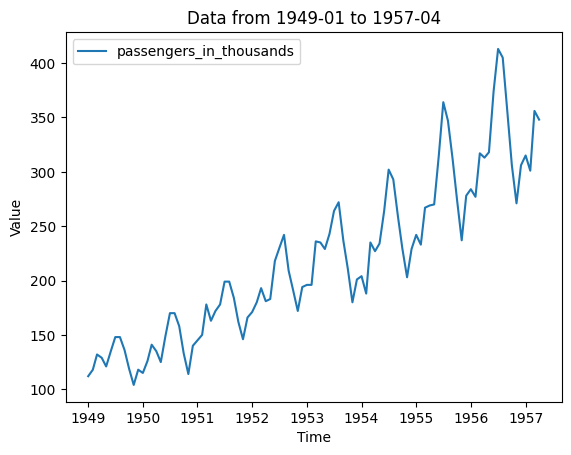

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/airline/airline.csv')

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path,parse_dates=['Month'],  index_col=['Month'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/airline/train.csv', '1949-01', '1957-04')

In [1]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster
from src.train import train, inference

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
timeseries_field = list(set(input_field + output_field))
datasetPath = 'data/airline'
t = 12
h = 4

if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')

train_df = pd.read_csv(f'{datasetPath}/train.csv')
test_df = pd.read_csv(f'{datasetPath}/test.csv')
val_df = pd.read_csv(f'{datasetPath}/val.csv')
scaler = Scaler(train_df[timeseries_field], 'minmax')

train_dataset = TimeSeriesDataset(train_df, input_field, output_field, t=t, h=h, scaler=scaler)
test_dataset = TimeSeriesDataset(test_df, input_field, output_field, t=t, h=h, scaler=scaler)
val_dataset = TimeSeriesDataset(val_df, input_field, output_field, t=t, h=h, scaler=scaler)

modelPath = 'out/LSTMForecaster_airline/n1_hs32_h4_t12/best.pth.tar'
model = LSTMForecaster(input_size=len(input_field), output_size=len(output_field)*h, hidden_size=32, num_layers=1)
model.to(device)

load_checkpoint(modelPath, model)

=> loaded checkpoint 'True' (epoch 2039)
Checkpoint's train loss is: 0.1727
Checkpoint's validation loss is: 0.8434


(2039, 0.17266018688678741, 0.8433916568756104)

In [24]:
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False)
for data, target in dataloader:
    data = data.to(device)
    target = target.flatten(start_dim=1).to(device)
    print(data)
    print(target)
    print(model(data))
    break

tensor([[[0.0259],
         [0.0453],
         [0.0906],
         [0.0809],
         [0.0550],
         [0.1003],
         [0.1424],
         [0.1424],
         [0.1036],
         [0.0485],
         [0.0000],
         [0.0453]],

        [[0.0453],
         [0.0906],
         [0.0809],
         [0.0550],
         [0.1003],
         [0.1424],
         [0.1424],
         [0.1036],
         [0.0485],
         [0.0000],
         [0.0453],
         [0.0356]],

        [[0.0906],
         [0.0809],
         [0.0550],
         [0.1003],
         [0.1424],
         [0.1424],
         [0.1036],
         [0.0485],
         [0.0000],
         [0.0453],
         [0.0356],
         [0.0712]],

        [[0.0809],
         [0.0550],
         [0.1003],
         [0.1424],
         [0.1424],
         [0.1036],
         [0.0485],
         [0.0000],
         [0.0453],
         [0.0356],
         [0.0712],
         [0.1197]]])
tensor([[0.0356, 0.0712, 0.1197, 0.1003],
        [0.0712, 0.1197, 0.1003, 0.068